# Exploring Security Practices in Infrastructure as Code: An Empirical Study of Google Terraform Configurations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.dpi'] = 300

In [2]:
RESULTS_FILE = "./csv/google_results.csv"
POLICIES_FILE = "./csv/google_policies.csv"
DATASET = "./csv/google_dataset_filtered.csv"
METRICS_FILE = "./csv/google_dataset_metrics.csv"

Retrieve the list of the 121 selected policies and their mapped categories.
We also print the policies list to use in the checkov_looper.py Python script.

In [3]:
categories = {}
policies = {}
p_names = {}
with open(POLICIES_FILE, 'r') as f:
    f.readline()
    policies_rows = f.readlines()
    for row in policies_rows:
        s_row = row.split(',')
        if s_row[5] == "TRUE":
            policy_id = s_row[1]
            policy_name = s_row[3]
            policy_description = s_row[4]
            policy_category = s_row[6].strip('\n')
            if policy_category == "":
                policy_category = "Uncategorized"

            policies[policy_id] = policy_description
            categories[policy_id] = policy_category
            p_names[policy_id] = policy_name

In [4]:
print("CHECK_LIST = " + ",".join(policies))

CHECK_LIST = CKV_GCP_1,CKV_GCP_2,CKV_GCP_3,CKV_GCP_6,CKV_GCP_8,CKV_GCP_11,CKV_GCP_15,CKV_GCP_16,CKV_GCP_18,CKV_GCP_19,CKV_GCP_23,CKV_GCP_25,CKV_GCP_26,CKV_GCP_28,CKV_GCP_29,CKV_GCP_31,CKV_GCP_32,CKV_GCP_36,CKV_GCP_37,CKV_GCP_38,CKV_GCP_40,CKV_GCP_42,CKV_GCP_44,CKV_GCP_45,CKV_GCP_51,CKV_GCP_52,CKV_GCP_53,CKV_GCP_54,CKV_GCP_55,CKV_GCP_56,CKV_GCP_57,CKV_GCP_60,CKV_GCP_61,CKV_GCP_62,CKV_GCP_63,CKV_GCP_64,CKV_GCP_74,CKV_GCP_75,CKV_GCP_76,CKV_GCP_79,CKV_GCP_80,CKV_GCP_81,CKV_GCP_83,CKV_GCP_84,CKV_GCP_85,CKV_GCP_86,CKV_GCP_87,CKV_GCP_88,CKV_GCP_89,CKV_GCP_90,CKV_GCP_91,CKV_GCP_92,CKV_GCP_93,CKV_GCP_94,CKV_GCP_96,CKV_GCP_97,CKV_GCP_98,CKV_GCP_99,CKV_GCP_100,CKV_GCP_101,CKV_GCP_102,CKV_GCP_103,CKV_GCP_104,CKV_GCP_105,CKV_GCP_106,CKV_GCP_107,CKV_GCP_108,CKV_GCP_109,CKV_GCP_111,CKV_GCP_112,CKV_GCP_113,CKV_GCP_114,CKV2_GCP_6,CKV2_GCP_7,CKV2_GCP_8,CKV2_GCP_9,CKV2_GCP_13,CKV2_GCP_14,CKV2_GCP_15,CKV2_GCP_16,CKV2_GCP_17,CKV2_GCP_18


## RQ1: Category Mapping Distribution

In [5]:
categories_count = {}
for policy in policies:
    categories_count[categories.get(policy, "Uncategorized")] = categories_count.get(categories.get(policy, "Uncategorized"), 0) + 1

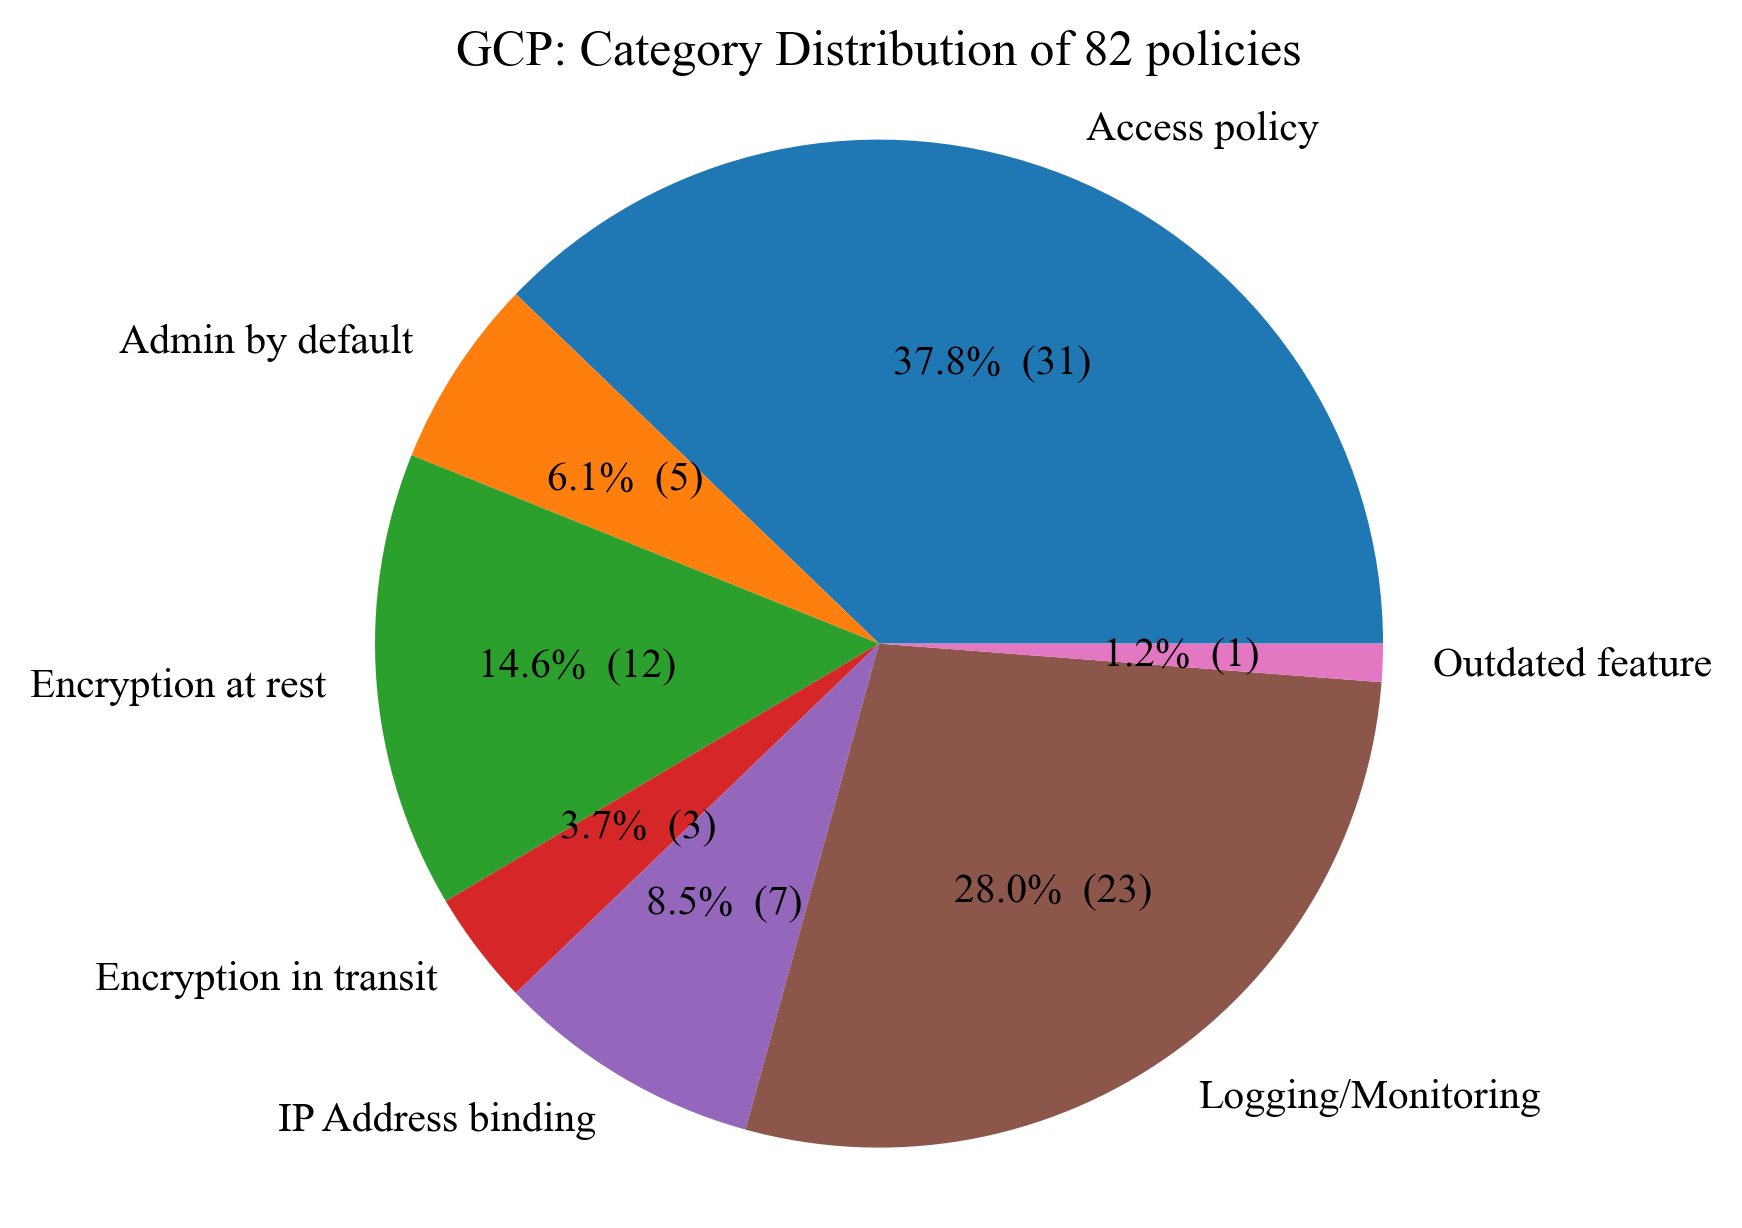

In [6]:
labels2 = sorted([*categories_count.keys()])
sizes2 = [categories_count[k] for k in labels2]
fig2, ax2 = plt.subplots()
ax2.pie(sizes2, labels=labels2, autopct=lambda p : '{:.1f}%  ({:,.0f})'.format(p,p * sum(sizes2)/100))
ax2.axis('equal')
ax2.set(title="GCP: Category Distribution of {} policies".format(len(policies)))
plt.show()

## Results analysis

Load the repository list of our dataset and the checkov results

In [7]:
with open(DATASET, 'r') as f:
    f.readline()
    tmp_repo_names = f.readlines()
repo_names = [k.strip("\n") for k in tmp_repo_names]

In [8]:
with open(RESULTS_FILE, 'r') as f:
    f.readline()
    repo_results = f.readlines()

Aggregate the results per category. Ensures all policies in the results are categorized (have been selected and mapped to a category).

In [9]:
passed_count_dict = {}
failed_count_dict = {}
categories_passed_counts = {}
categories_failed_counts = {}
uncategorized_policies = {}
repo_results_list = []
for row in repo_results:
    columns = row.split(',')
    repo_name = columns[0]
    if repo_name in repo_names:
        passed_policies = columns[3].split(';')
        failed_policies = columns[4].split(';')
        repo_results_list.append([len(passed_policies), len(failed_policies)])

        for policy in passed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_passed_counts[categories.get(policy, "Uncategorized")] = categories_passed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                passed_count_dict[policy] = passed_count_dict.get(policy, 0) + 1
                
        for policy in failed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_failed_counts[categories.get(policy, "Uncategorized")] = categories_failed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                failed_count_dict[policy] = failed_count_dict.get(policy, 0) + 1
                

total_count = {}
for policy in passed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + passed_count_dict[policy]
for policy in failed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + failed_count_dict[policy]
                    
print("Uncategorized policies: {}".format([*uncategorized_policies.keys()]))
print("Total number of passed policies: {}".format(sum(passed_count_dict.values())))
print("Total number of failed policies: {}".format(sum(failed_count_dict.values())))
print("Median number of checks per policy: {}".format(np.median([*total_count.values()])))
print("Average number of checks per policy: {}".format(np.average([*total_count.values()])))
print("STD of checks per policy: {}".format(np.std([*total_count.values()])))
print("Skewness of checks per policy: {}".format(sp.skew([*total_count.values()])))
print("Skewness of checks per policy: {}".format((np.average([*total_count.values()])-np.median([*total_count.values()]))/np.std([*total_count.values()])))

Uncategorized policies: []
Total number of passed policies: 14821
Total number of failed policies: 8306
Median number of checks per policy: 201.0
Average number of checks per policy: 282.0365853658537
STD of checks per policy: 331.5270082483422
Skewness of checks per policy: 2.4396250764886473
Skewness of checks per policy: 0.2444343397360565


In [10]:
nb_of_checks = []
for i in repo_results_list:
    nb_of_checks.append(i[0]+i[1])
rate_list = []
for i in repo_results_list:
    rate_list.append(100*i[0]/(i[0]+i[1]))
    
print("Median number of checks per repo: {}".format(np.median(nb_of_checks)))
print("Average number of checks per repo: {}".format(np.average(nb_of_checks)))
print("STD of checks per repo: {}".format(np.std(nb_of_checks)))
print("Skewness of checks per repo: {}".format((np.average(nb_of_checks)-np.median(nb_of_checks))/np.std(nb_of_checks)))
print("\n")
print("Median pass rate per repo: {}".format(np.median(rate_list)))
print("Average pass rate per repo: {}".format(np.average(rate_list)))

Median number of checks per repo: 22.0
Average number of checks per repo: 108.65727699530517
STD of checks per repo: 340.8342428989367
Skewness of checks per repo: 0.25425050094218543


Median pass rate per repo: 57.142857142857146
Average pass rate per repo: 55.92384897268786


### Generate the Paper Full Table with the results

In [11]:
inv_cat = {}
for k, v in categories.items():
    inv_cat[v] = inv_cat.get(v, []) + [k]
tp = ""
for cat in inv_cat:
    p = inv_cat[cat]
    tp = tp + "\multirow{" + str(len(p)) + "}{*}{" + cat + "}"
    for i in p:
        if total_count.get(i,0) != 0:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " + str(passed_count_dict.get(i,0)/total_count.get(i,0)*100)[:5] +"\\\\ \n"
        else:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " +"\\\\ \n"
    tp = tp + "\hline \n"
tp = tp.replace("_", "\_")
print(tp)

\multirow{23}{*}{Logging/Monitoring} & Ensure Stackdriver Logging is set to Enabled on Kubernetes Engine Clusters & 310 & 305 & 5 & 98.38\\ 
 & Ensure Stackdriver Monitoring is set to Enabled on Kubernetes Engine Clusters & 310 & 307 & 3 & 99.03\\ 
 & Ensure that VPC Flow Logs is enabled for every subnet in a VPC Network & 585 & 93 & 492 & 15.89\\ 
 & Ensure PostgreSQL database 'log\_checkpoints' flag is set to 'on' & 105 & 10 & 95 & 9.523\\ 
 & Ensure PostgreSQL database 'log\_connections' flag is set to 'on' & 105 & 15 & 90 & 14.28\\ 
 & Ensure PostgreSQL database 'log\_disconnections' flag is set to 'on' & 105 & 13 & 92 & 12.38\\ 
 & Ensure PostgreSQL database 'log\_lock\_waits' flag is set to 'on' & 105 & 15 & 90 & 14.28\\ 
 & Ensure PostgreSQL database 'log\_min\_messages' flag is set to a valid value & 105 & 89 & 16 & 84.76\\ 
 & Ensure PostgreSQL database 'log\_temp\_files flag is set to '0' & 105 & 88 & 17 & 83.80\\ 
 & Ensure PostgreSQL database 'log\_min\_duration\_statement'

## RQ2/RQ3 : Category Pass/Fail Rate

In [12]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 0:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

categories_rates = {}
for category in [*categories.values()]:
    categories_rates[category] = categories_passed_counts[category] / (categories_passed_counts[category] + categories_failed_counts.get(category, 0))

#categories_rates = {}
#for policy in policies_rate:
 #   categories_rates[categories[policy]] = categories_rates.get(categories[policy], []) + [policies_rate[policy]]
#for category in categories_rates:
 #   categories_rates[category] = np.average(categories_rates.get(category, []))
print(categories_rates)
print(categories_failed_counts)

{'Logging/Monitoring': 0.5093111958716625, 'Access policy': 0.7243068584531999, 'Encryption in transit': 0.03535353535353535, 'IP Address binding': 0.6225429975429976, 'Admin by default': 0.9877862595419847, 'Encryption at rest': 0.13797634691195795, 'Outdated feature': 0.44155844155844154}
{'Access policy': 2645, 'Logging/Monitoring': 2187, 'Encryption in transit': 764, 'Encryption at rest': 1312, 'IP Address binding': 1229, 'Outdated feature': 129, 'Admin by default': 40}


In [13]:
import pickle
with open('./google_categories_rates.pkl', 'wb') as f:
    pickle.dump(categories_rates, f)

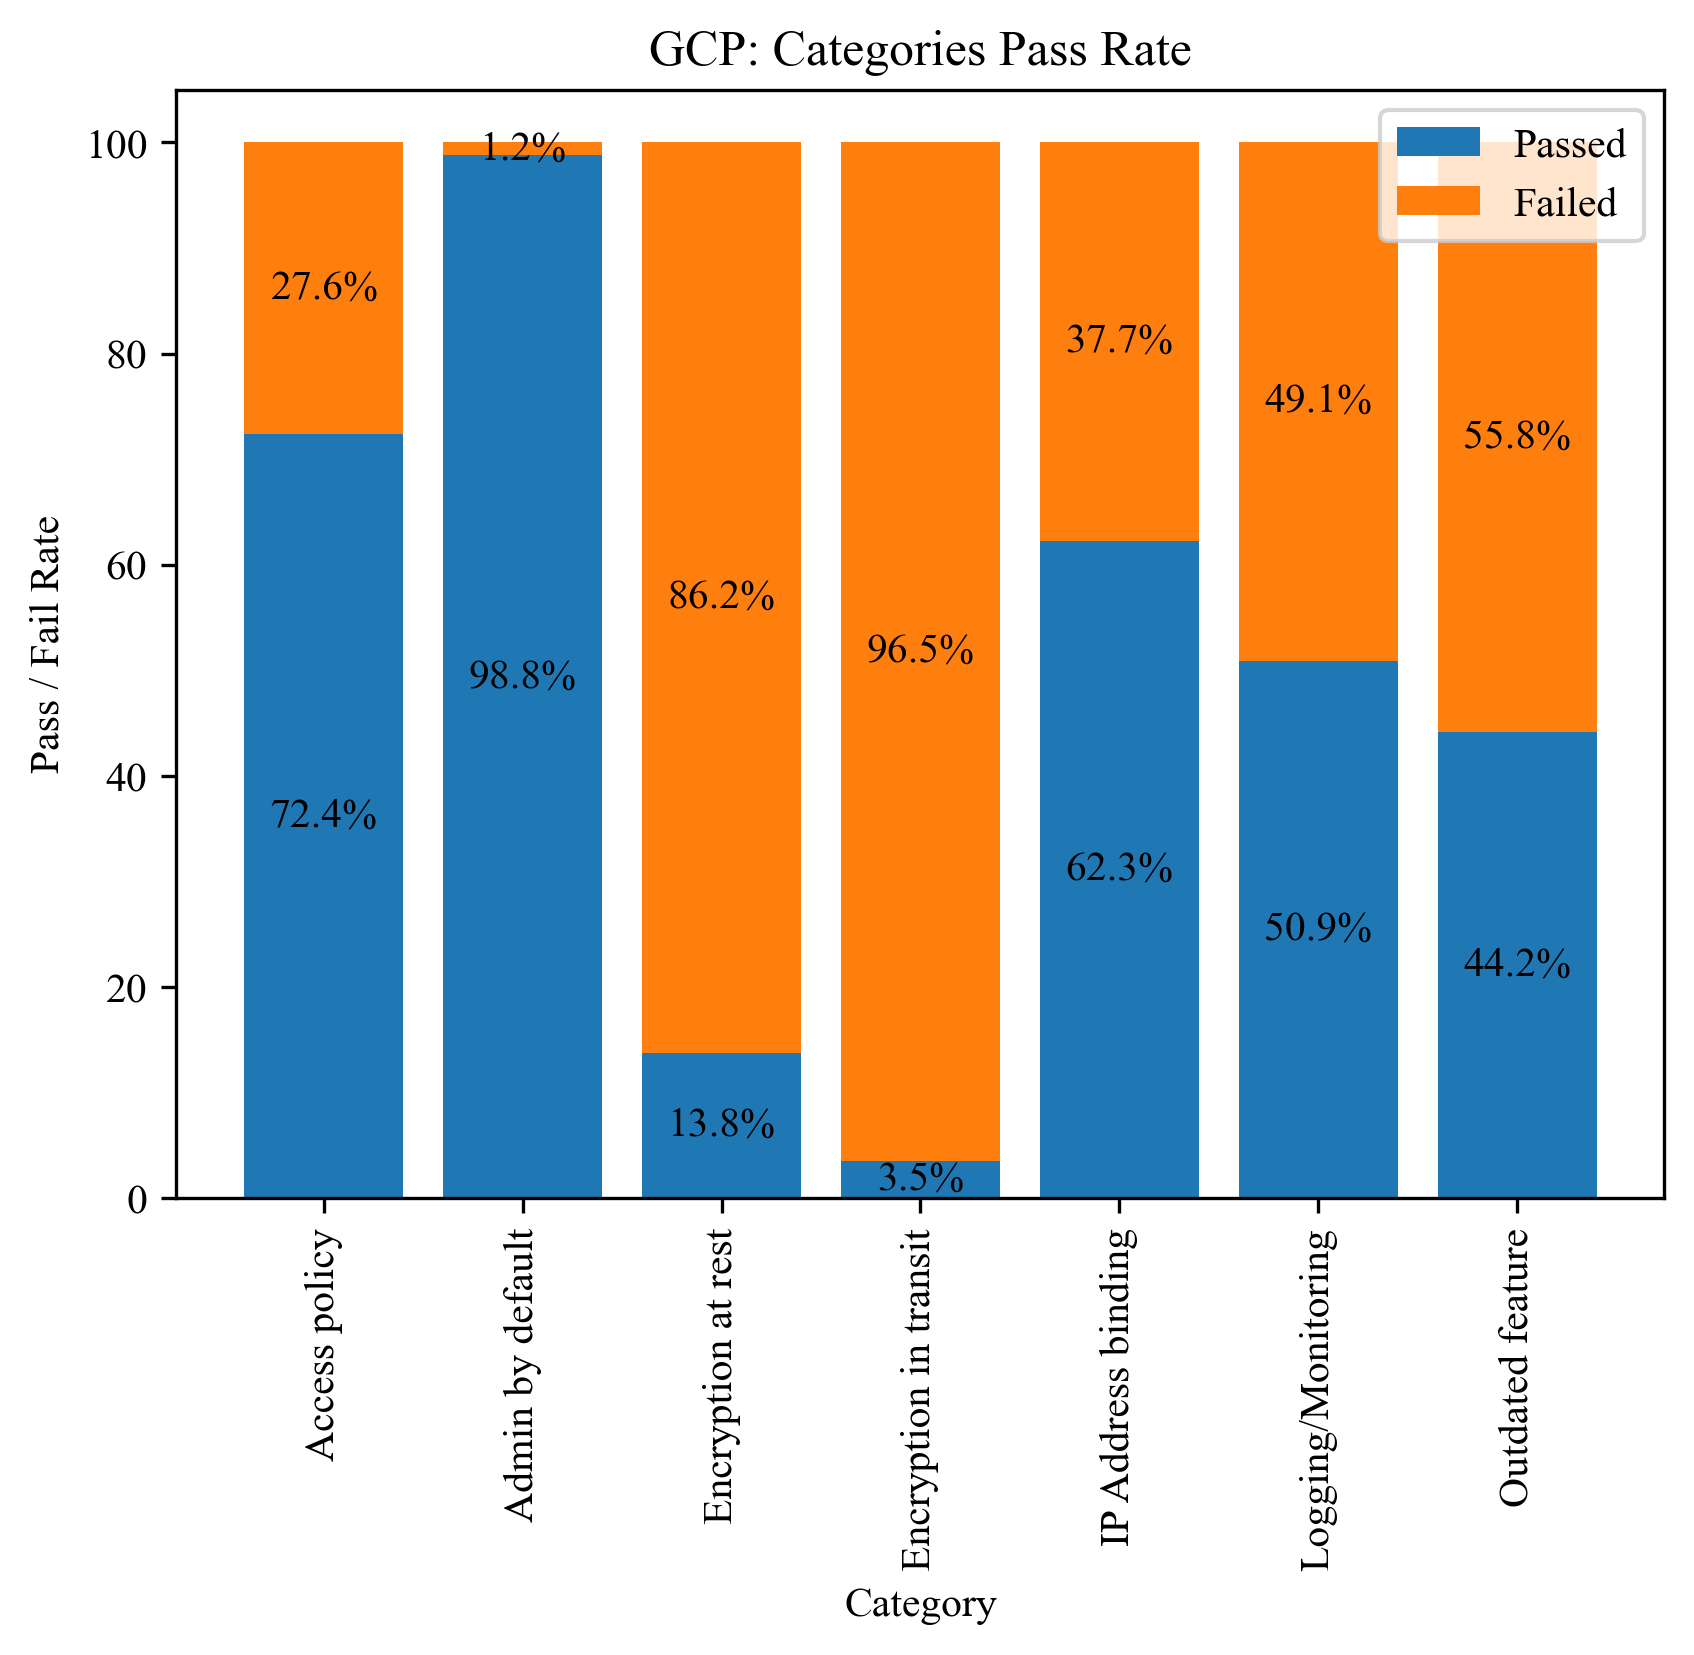

In [14]:
fig7, ax7 = plt.subplots()
x = sorted([*categories_rates.keys()])
y1 = [100*categories_rates[k] for k in x]
y2 = [100-k for k in y1]
bc1 = ax7.bar(x, y1)
bc2 = ax7.bar(x, y2, bottom=y1)
ax7.bar_label(bc1, labels=['{0:.1f}%'.format(e) for e in y1], label_type='center')
ax7.bar_label(bc2, labels=['{0:.1f}%'.format(e) for e in y2], label_type='center')
ax7.set(xlabel="Category", ylabel="Pass / Fail Rate", title="GCP: Categories Pass Rate")
ax7.legend(["Passed", "Failed"])
plt.xticks(rotation=90)
plt.show()

## RQ2/RQ3 : Best and Worst Pass/Fail Policies

In [15]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 50:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

print("Averate Pass/Fail Rate: {}".format(np.average([*policies_rate.values()])))
        
sorted_policies_rates = sorted(policies_rate, key=policies_rate.get, reverse=True)
print("Best 5 Pass / Fail Rate Policies")
for policy in sorted_policies_rates[:6]:
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))
print("Worst 5 Pass / Fail Rate Policies")
for policy in reversed(sorted_policies_rates[-7:]):
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))

Averate Pass/Fail Rate: 0.5626998766483906
Best 5 Pass / Fail Rate Policies
CKV_GCP_63 - 69 - 1.0
CKV_GCP_112 - 161 - 1.0
CKV2_GCP_14 - 243 - 1.0
CKV2_GCP_15 - 243 - 1.0
CKV2_GCP_16 - 243 - 1.0
CKV2_GCP_17 - 243 - 1.0
Worst 5 Pass / Fail Rate Policies
CKV_GCP_111 - 105 - 0.0
CKV_GCP_108 - 105 - 0.0
CKV_GCP_76 - 593 - 0.003372681281618887
CKV_GCP_61 - 310 - 0.0064516129032258064
CKV_GCP_109 - 105 - 0.009523809523809525
CKV_GCP_114 - 586 - 0.011945392491467578
CKV_GCP_84 - 63 - 0.031746031746031744


Print Average number of test per category

In [16]:
policies_nb_runs = {}
for policy in policies:
    policies_nb_runs[policy] = passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)

mean_category_runs = {}
for policy in policies_nb_runs:
    mean_category_runs[categories.get(policy, "Uncategorized")] = mean_category_runs.get(categories.get(policy, "Uncategorized"), []) + [policies_nb_runs[policy]]

for category in mean_category_runs:
    print(str(category) +" "+ str(np.sum(mean_category_runs[category])))
    mean_category_runs[category] = np.average(mean_category_runs[category])
print(mean_category_runs)

Logging/Monitoring 4457
Access policy 9594
Encryption in transit 792
IP Address binding 3256
Admin by default 3275
Encryption at rest 1522
Outdated feature 231
{'Logging/Monitoring': 193.7826086956522, 'Access policy': 309.48387096774195, 'Encryption in transit': 264.0, 'IP Address binding': 465.14285714285717, 'Admin by default': 655.0, 'Encryption at rest': 126.83333333333333, 'Outdated feature': 231.0}


In [17]:
stars = []
forks = []
contrib = []
with open(METRICS_FILE, 'r') as f:
    #f.readline()
    rows = f.readlines()
    for item in rows:
        column = item.split(',')
        if column[0] in repo_names:
            stars.append(int(column[1]))
            forks.append(int(column[2]))
            contrib.append(int(column[3].strip("\n")))

In [18]:
print("Average stars: {}".format(np.average(stars)))
print("Median stars: {}".format(np.median(stars)))
print("Average forks: {}".format(np.average(forks)))
print("Median forks: {}".format(np.median(forks)))
print("Average conrtib: {}".format(np.average(contrib)))
print("Median contrib: {}".format(np.median(contrib)))

Average stars: 281.31021897810217
Median stars: 9.5
Average forks: 95.36861313868613
Median forks: 5.0
Average conrtib: 9.89051094890511
Median contrib: 4.0
